In [ ]:
import os
import zipfile
import shutil
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths
zip_path = '/content/drive/MyDrive/ISBI2016_ISIC_Part3B_Training_Data.zip'
extract_path = '/content/ISIC_extracted'
jpg_save_path = '/content/drive/MyDrive/ISIC_JPGs'
png_save_path = '/content/drive/MyDrive/ISIC_PNGs'

# Clean and create folders
for folder in [jpg_save_path, png_save_path]:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(f"✅ Extracted to: {extract_path}")

# Move JPG and PNG files to respective folders
jpg_count = 0
png_count = 0
for root, _, files in os.walk(extract_path):
    for file in files:
        if file.lower().endswith('.jpg'):
            shutil.copy(os.path.join(root, file), os.path.join(jpg_save_path, file))
            jpg_count += 1
        elif file.lower().endswith('.png'):
            shutil.copy(os.path.join(root, file), os.path.join(png_save_path, file))
            png_count += 1

print(f"✅ {jpg_count} JPG files copied to: {jpg_save_path}")
print(f"✅ {png_count} PNG files copied to: {png_save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Extracted to: /content/ISIC_extracted
✅ 900 JPG files copied to: /content/drive/MyDrive/ISIC_JPGs
✅ 900 PNG files copied to: /content/drive/MyDrive/ISIC_PNGs


🧮 Total image pairs to check: 900


/tmp/ipython-input-1295915244.py:56: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


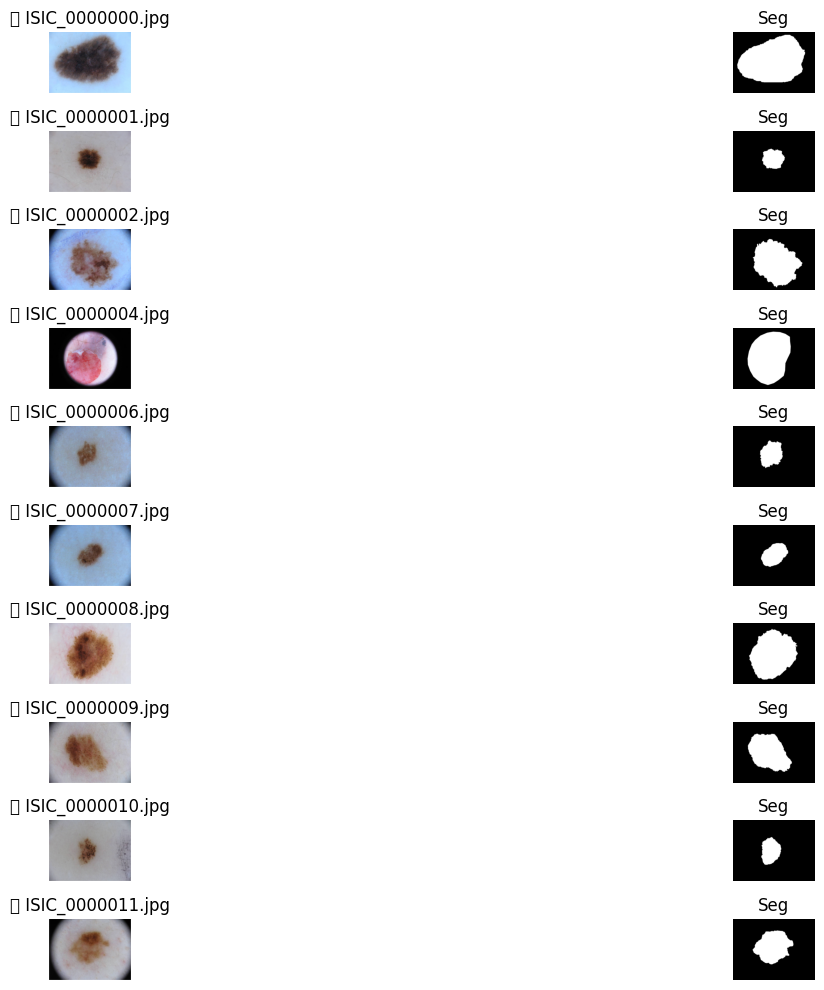

✅ No mismatches in this batch.


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Your image folders
jpg_folder = '/content/drive/MyDrive/ISIC_JPGs'
png_folder = '/content/drive/MyDrive/ISIC_PNGs'

# List all files
jpg_files = sorted([f for f in os.listdir(jpg_folder) if f.lower().endswith('.jpg')])
png_files = sorted([f for f in os.listdir(png_folder) if f.lower().endswith('.png')])

# Ensure same number of files
total = min(len(jpg_files), len(png_files))
print(f"🧮 Total image pairs to check: {total}")

def show_image_batch(batch_num=0, batch_size=20):
    start = batch_num * batch_size
    end = min(start + batch_size, total)

    mismatches = []

    plt.figure(figsize=(20, batch_size))
    for idx, i in enumerate(range(start, end)):
        jpg_path = os.path.join(jpg_folder, jpg_files[i])
        png_path = os.path.join(png_folder, png_files[i])

        img_jpg = cv2.imread(jpg_path)
        img_png = cv2.imread(png_path)

        if img_jpg is None or img_png is None:
            print(f"🚫 Failed to load: {jpg_files[i]} or {png_files[i]}")
            continue

        # Check size mismatch
        if img_jpg.shape[:2] != img_png.shape[:2]:
            mismatches.append((i, jpg_files[i], img_jpg.shape, img_png.shape))
            title = f"❌ {jpg_files[i]}"
        else:
            title = f"✅ {jpg_files[i]}"

        # Convert from BGR to RGB
        img_rgb = cv2.cvtColor(img_jpg, cv2.COLOR_BGR2RGB)
        plt.subplot(batch_size, 2, 2 * idx + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(title)

        img_mask = cv2.cvtColor(img_png, cv2.COLOR_BGR2RGB)
        plt.subplot(batch_size, 2, 2 * idx + 2)
        plt.imshow(img_mask)
        plt.axis('off')
        plt.title("Seg")

    plt.tight_layout()
    plt.show()

    if mismatches:
        print(f"\n❗ Mismatched images in this batch:")
        for item in mismatches:
            print(f"[{item[0]}] {item[1]} - JPG: {item[2]} vs PNG: {item[3]}")
    else:
        print("✅ No mismatches in this batch.")

# Run this for the first batch
show_image_batch(batch_num=0, batch_size=10)  # You can change to batch_num=1,2,... to see more


In [ ]:
import os
import shutil
import pandas as pd

# === PATHS ===
csv_path = '/content/drive/MyDrive/ISBI2016_ISIC_Part3B_Training_GroundTruth.csv'
jpg_folder = '/content/drive/MyDrive/ISIC_JPGs'
png_folder = '/content/drive/MyDrive/ISIC_PNGs'

# === OUTPUT FOLDERS ===
sorted_jpg_folder = '/content/drive/MyDrive/Sorted_JPGs'
sorted_png_folder = '/content/drive/MyDrive/Sorted_PNGs'

# Create output directories
for folder in [sorted_jpg_folder, sorted_png_folder]:
    for cls in ['benign', 'malignant']:
        os.makedirs(os.path.join(folder, cls), exist_ok=True)

# === READ CSV ===
df = pd.read_csv(csv_path, sep='\t', header=None, names=['image_name', 'type'])

# Drop rows with missing values
df = df.dropna()

# Make sure both columns are strings
df['image_name'] = df['image_name'].astype(str)
df['type'] = df['type'].astype(str)

# === PROCESS IMAGES ===
for idx, row in df.iterrows():
    img_name = row['image_name'].strip()
    img_type = row['type'].strip().lower()

    # File paths
    jpg_src = os.path.join(jpg_folder, f"{img_name}.jpg")
    png_src = os.path.join(png_folder, f"{img_name}.png")

    jpg_dest = os.path.join(sorted_jpg_folder, img_type, f"{img_name}.jpg")
    png_dest = os.path.join(sorted_png_folder, img_type, f"{img_name}.png")

    # Copy if exists
    if os.path.exists(jpg_src):
        shutil.copy2(jpg_src, jpg_dest)
    else:
        print(f"❌ JPG not found: {jpg_src}")

    if os.path.exists(png_src):
        shutil.copy2(png_src, png_dest)
    else:
        print(f"❌ PNG not found: {png_src}")


In [ ]:
import os
import shutil
import pandas as pd
from tqdm import tqdm

# --- Paths ---
csv_path = "/content/drive/MyDrive/ISBI2016_ISIC_Part3B_Training_GroundTruth.csv"
image_dir = "/content/drive/MyDrive/ISIC_JPGs"  # Actual image folder
output_dir = "/content/drive/MyDrive/ISIC_Separated"

# --- Create output directories ---
benign_dir = os.path.join(output_dir, "benign")
malignant_dir = os.path.join(output_dir, "malignant")
os.makedirs(benign_dir, exist_ok=True)
os.makedirs(malignant_dir, exist_ok=True)

# --- Load CSV ---
df = pd.read_csv(csv_path, header=None)
df.columns = ["image_id", "label"]  # Explicitly rename columns for clarity

# --- Track missing images ---
missing_images = []

# --- Copy images ---
print("Separating images into benign and malignant folders...\n")

for _, row in tqdm(df.iterrows(), total=len(df)):
    img_id = row["image_id"]
    label = row["label"].strip().lower()  # ensure consistency
    src_path = os.path.join(image_dir, img_id + ".jpg")

    if not os.path.exists(src_path):
        missing_images.append(src_path)
        continue

    if label == "benign":
        dst_path = os.path.join(benign_dir, img_id + ".jpg")
    elif label == "malignant":
        dst_path = os.path.join(malignant_dir, img_id + ".jpg")
    else:
        continue  # skip unknown labels

    shutil.copy2(src_path, dst_path)

# --- Report missing images ---
print(f"\n✅ Completed. Total missing images: {len(missing_images)}")
if missing_images:
    print("\nSome images were not found:")
    for m in missing_images[:10]:  # Show only first 10 for brevity
        print("Image not found:", m)


Separating images into benign and malignant folders...



100%|██████████| 900/900 [00:36<00:00, 24.89it/s]


✅ Completed. Total missing images: 0


In [ ]:
import os
import shutil
import pandas as pd
from tqdm import tqdm

# --- Paths ---
csv_path = "/content/drive/MyDrive/ISBI2016_ISIC_Part3B_Training_GroundTruth.csv"
seg_image_dir = "/content/drive/MyDrive/ISIC_PNGs"  # PNG segmentation folder
output_seg_dir = "/content/drive/MyDrive/ISIC_Separated_Segmentations"

# --- Create output directories ---
benign_seg_dir = os.path.join(output_seg_dir, "benign")
malignant_seg_dir = os.path.join(output_seg_dir, "malignant")
os.makedirs(benign_seg_dir, exist_ok=True)
os.makedirs(malignant_seg_dir, exist_ok=True)

# --- Load CSV ---
df = pd.read_csv(csv_path, header=None)
df.columns = ["image_id", "label"]

# --- Track missing segmentations ---
missing_segs = []

# --- Copy segmentation masks ---
print("Separating segmentation masks into benign and malignant folders...\n")

for _, row in tqdm(df.iterrows(), total=len(df)):
    img_id = row["image_id"]
    label = row["label"].strip().lower()

    seg_filename = img_id + "_Segmentation.png"
    src_path = os.path.join(seg_image_dir, seg_filename)

    if not os.path.exists(src_path):
        missing_segs.append(src_path)
        continue

    if label == "benign":
        dst_path = os.path.join(benign_seg_dir, seg_filename)
    elif label == "malignant":
        dst_path = os.path.join(malignant_seg_dir, seg_filename)
    else:
        continue  # unknown label

    shutil.copy2(src_path, dst_path)

# --- Report missing masks ---
print(f"\n✅ Completed. Total missing segmentation masks: {len(missing_segs)}")
if missing_segs:
    print("\nSome segmentations were not found:")
    for m in missing_segs[:10]:  # Show first 10
        print("Segmentation not found:", m)


Separating segmentation masks into benign and malignant folders...



100%|██████████| 900/900 [00:23<00:00, 37.81it/s] 


✅ Completed. Total missing segmentation masks: 0


Loading malignant: 100%|██████████| 173/173 [00:18<00:00,  9.46it/s]



✅ Saved benign_images.npy and malignant_images.npy in /content/drive/MyDrive/ISIC_Image_NPY
Benign shape: (727, 256, 256, 3), Malignant shape: (173, 256, 256, 3)


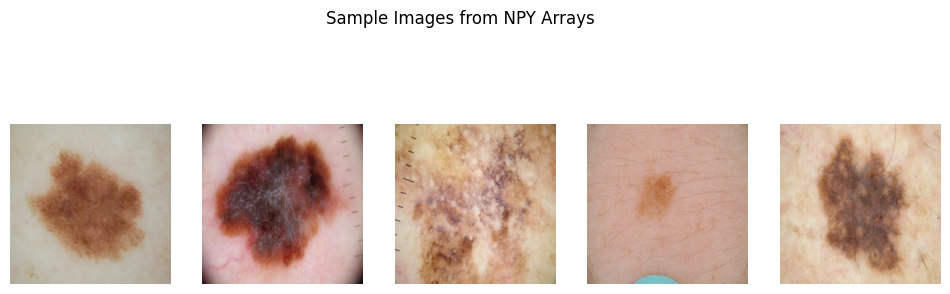

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# --- Paths ---
benign_dir = "/content/drive/MyDrive/ISIC_Separated/benign"
malignant_dir = "/content/drive/MyDrive/ISIC_Separated/malignant"
output_dir = "/content/drive/MyDrive/ISIC_Image_NPY"
os.makedirs(output_dir, exist_ok=True)

# --- Resize target ---
IMG_SIZE = (256, 256)

# --- Function to load & resize images ---
def load_images_from_folder(folder):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in tqdm(filenames, desc=f"Loading {os.path.basename(folder)}"):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert("RGB")
            img = img.resize(IMG_SIZE)               # resize to fixed size
            img = np.array(img, dtype=np.uint8)
            images.append(img)
    return np.array(images)

# --- Load datasets ---
benign_array = load_images_from_folder(benign_dir)
malignant_array = load_images_from_folder(malignant_dir)

# --- Save as .npy ---
np.save(os.path.join(output_dir, "benign_images.npy"), benign_array)
np.save(os.path.join(output_dir, "malignant_images.npy"), malignant_array)

print(f"\n✅ Saved benign_images.npy and malignant_images.npy in {output_dir}")
print(f"Benign shape: {benign_array.shape}, Malignant shape: {malignant_array.shape}")

# --- Visualize 5 random images ---
all_images = np.concatenate([benign_array, malignant_array], axis=0)
plt.figure(figsize=(12, 4))
for i, idx in enumerate(random.sample(range(len(all_images)), 5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(all_images[idx])
    plt.axis("off")
plt.suptitle("Sample Images from NPY Arrays")
plt.show()


Loading malignant: 100%|██████████| 173/173 [00:06<00:00, 25.40it/s]



✅ Saved benign_images.npy and malignant_images.npy in /content/drive/MyDrive/ISIC_Image_NPY
Benign shape: (727, 256, 256, 3), Malignant shape: (173, 256, 256, 3)


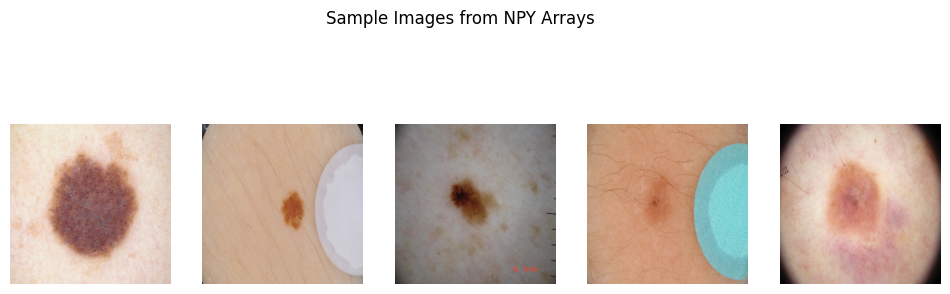

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# --- Paths ---
benign_dir = "/content/drive/MyDrive/ISIC_Separated/benign"
malignant_dir = "/content/drive/MyDrive/ISIC_Separated/malignant"
output_dir = "/content/drive/MyDrive/ISIC_Image_NPY"
os.makedirs(output_dir, exist_ok=True)

# --- Resize target (change if needed) ---
IMG_SIZE = (256, 256)

# --- Function to load and resize images ---
def load_images_from_folder(folder):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in tqdm(filenames, desc=f"Loading {os.path.basename(folder)}"):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert("RGB")
            img = img.resize(IMG_SIZE)               # resize to fixed size
            img = np.array(img, dtype=np.uint8)
            images.append(img)
    return np.array(images)

# --- Load datasets ---
benign_array = load_images_from_folder(benign_dir)
malignant_array = load_images_from_folder(malignant_dir)

# --- Save as .npy ---
np.save(os.path.join(output_dir, "benign_images.npy"), benign_array)
np.save(os.path.join(output_dir, "malignant_images.npy"), malignant_array)

print(f"\n✅ Saved benign_images.npy and malignant_images.npy in {output_dir}")
print(f"Benign shape: {benign_array.shape}, Malignant shape: {malignant_array.shape}")

# --- Visualize 5 random images ---
all_images = np.concatenate([benign_array, malignant_array], axis=0)
plt.figure(figsize=(12, 4))
for i, idx in enumerate(random.sample(range(len(all_images)), 5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(all_images[idx])
    plt.axis("off")
plt.suptitle("Sample Images from NPY Arrays")
plt.show()


Loading masks from malignant: 100%|██████████| 173/173 [00:02<00:00, 57.77it/s] 



✅ Saved benign_masks.npy and malignant_masks.npy in /content/drive/MyDrive/ISIC_Segmentation_NPY
Benign masks shape: (727, 256, 256), Malignant masks shape: (173, 256, 256)


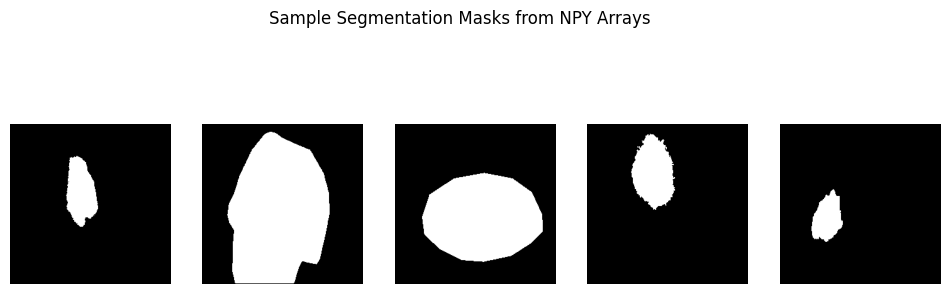

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# --- Paths ---
benign_seg_dir = "/content/drive/MyDrive/ISIC_Separated_Segmentations/benign"
malignant_seg_dir = "/content/drive/MyDrive/ISIC_Separated_Segmentations/malignant"
output_dir = "/content/drive/MyDrive/ISIC_Segmentation_NPY"
os.makedirs(output_dir, exist_ok=True)

# --- Resize target ---
IMG_SIZE = (256, 256)

# --- Function to load and resize segmentation masks ---
def load_masks_from_folder(folder):
    masks = []
    filenames = sorted(os.listdir(folder))
    for filename in tqdm(filenames, desc=f"Loading masks from {os.path.basename(folder)}"):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            mask_path = os.path.join(folder, filename)
            mask = Image.open(mask_path).convert("L")   # convert to grayscale
            mask = mask.resize(IMG_SIZE, Image.NEAREST) # nearest to preserve mask edges
            mask = np.array(mask, dtype=np.uint8)
            masks.append(mask)
    return np.array(masks)

# --- Load datasets ---
benign_masks = load_masks_from_folder(benign_seg_dir)
malignant_masks = load_masks_from_folder(malignant_seg_dir)

# --- Save as .npy ---
np.save(os.path.join(output_dir, "benign_masks.npy"), benign_masks)
np.save(os.path.join(output_dir, "malignant_masks.npy"), malignant_masks)

print(f"\n✅ Saved benign_masks.npy and malignant_masks.npy in {output_dir}")
print(f"Benign masks shape: {benign_masks.shape}, Malignant masks shape: {malignant_masks.shape}")

# --- Visualize 5 random masks ---
all_masks = np.concatenate([benign_masks, malignant_masks], axis=0)
plt.figure(figsize=(12, 4))
for i, idx in enumerate(random.sample(range(len(all_masks)), 5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(all_masks[idx], cmap="gray")
    plt.axis("off")
plt.suptitle("Sample Segmentation Masks from NPY Arrays")
plt.show()


Shape: (727, 256, 256)
Data type: uint8


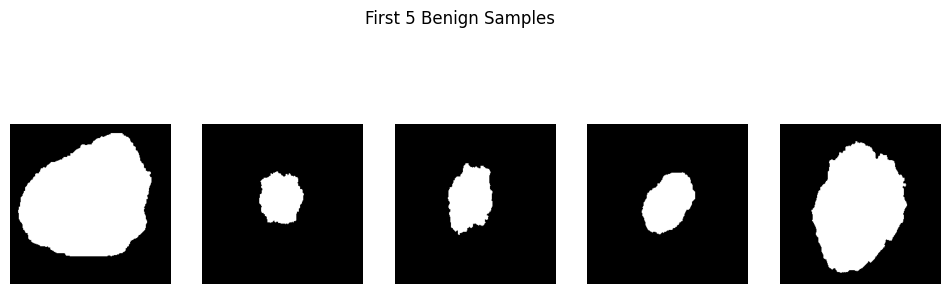

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Path to the benign npy file ---
npy_path = "/content/drive/MyDrive/ISIC_Segmentation_NPY/benign_masks.npy"  # change to benign_images.npy if needed

# --- Load the array ---
benign_data = np.load(npy_path)

print(f"Shape: {benign_data.shape}")
print(f"Data type: {benign_data.dtype}")

# --- Show first 5 ---
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    # If grayscale mask, use cmap="gray"
    if benign_data.ndim == 3:  # masks (H, W, C) or (H, W)
        plt.imshow(benign_data[i], cmap="gray")
    else:
        plt.imshow(benign_data[i])
    plt.axis("off")
plt.suptitle("First 5 Benign Samples")
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# =================================
# 1️⃣ UNet++ MODEL DEFINITION
# =================================
def convolution_block(x, num_filters, kernel_size=3):
    x = layers.Conv2D(num_filters, kernel_size, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def encoder(input_tensor):
    base_model = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=input_tensor
    )
    skips = [
        base_model.get_layer("conv1_relu").output,
        base_model.get_layer("conv2_block3_2_relu").output,
        base_model.get_layer("conv3_block4_2_relu").output,
        base_model.get_layer("conv4_block6_2_relu").output
    ]
    encoder_output = base_model.get_layer("conv5_block3_out").output
    return skips, encoder_output

def decoder(skips, encoder_output, num_classes):
    x = encoder_output
    x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = layers.Concatenate()([x, skips[3]])
    x = convolution_block(x, 256)

    x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = layers.Concatenate()([x, skips[2]])
    x = convolution_block(x, 128)

    x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = layers.Concatenate()([x, skips[1]])
    x = convolution_block(x, 64)

    x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = layers.Concatenate()([x, skips[0]])
    x = convolution_block(x, 32)

    x = layers.Conv2D(num_classes, (1, 1), padding="same")(x)
    return x

def UNetPP(image_size, num_classes):
    inputs = keras.Input(shape=(image_size, image_size, 3))
    skips, encoder_output = encoder(inputs)
    outputs = decoder(skips, encoder_output, num_classes)
    return keras.Model(inputs, outputs)

# =================================
# 2️⃣ LOAD DATA
# =================================
benign_images = np.load("/content/drive/MyDrive/ISIC_Image_NPY/benign_images.npy")
malignant_images = np.load("/content/drive/MyDrive/ISIC_Image_NPY/malignant_images.npy")
benign_masks = np.load("/content/drive/MyDrive/ISIC_Segmentation_NPY/benign_masks.npy")
malignant_masks = np.load("/content/drive/MyDrive/ISIC_Segmentation_NPY/malignant_masks.npy")

X = np.concatenate([benign_images, malignant_images], axis=0)
y = np.concatenate([benign_masks, malignant_masks], axis=0)

X = X.astype("float32") / 255.0
y = (y > 127).astype("float32")
y = np.expand_dims(y, axis=-1)

print("Images shape:", X.shape)
print("Masks shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =================================
# 3️⃣ LOSS FUNCTION
# =================================
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.nn.sigmoid(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 1 - (2. * intersection + 1) / (union + 1)

loss_fn = lambda y_true, y_pred: tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_true, y_pred) + dice_loss(y_true, y_pred)

# =================================
# 4️⃣ CREATE & TRAIN MODEL
# =================================
IMAGE_SIZE = X.shape[1]
NUM_CLASSES = 1

model = UNetPP(IMAGE_SIZE, NUM_CLASSES)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=loss_fn,
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)]
)

model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=20
)

# =================================
# 5️⃣ VISUALIZE RESULTS
# =================================
preds = model.predict(X_test[:5])
preds = tf.nn.sigmoid(preds).numpy()

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[i])
    plt.axis("off")
    if i == 0: plt.title("Image")

    plt.subplot(3, 5, i+6)
    plt.imshow(y_test[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == 0: plt.title("True Mask")

    plt.subplot(3, 5, i+11)
    plt.imshow(preds[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == 0: plt.title("Pred Mask")

plt.tight_layout()
plt.show()


Images shape: (900, 256, 256, 3)
Masks shape: (900, 256, 256, 1)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 29,488,385 (112.49 MB)

 Trainable params: 29,434,305 (112.28 MB)

 Non-trainable params: 54,080 (211.25 KB)

Epoch 1/20


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(8, 256, 256, 1), output.shape=(8, 128, 128, 1)

In [ ]:
import numpy as np
from PIL import Image
import os

# --- Paths ---
benign_path = "/content/drive/MyDrive/ISIC_Segmentation_NPY/benign_masks.npy"
malignant_path = "/content/drive/MyDrive/ISIC_Segmentation_NPY/malignant_masks.npy"

benign_out_path = "/content/drive/MyDrive/ISIC_Segmentation_NPY/benign_masks_resized.npy"
malignant_out_path = "/content/drive/MyDrive/ISIC_Segmentation_NPY/malignant_masks_resized.npy"

# --- Target Size ---
TARGET_SIZE = (128, 128)  # change to whatever size you want

def resize_npy(npy_path, output_path):
    # Load array
    arr = np.load(npy_path, allow_pickle=True)
    resized_arr = []

    for mask in arr:
        # Ensure mask is in uint8 for PIL
        mask_img = Image.fromarray(mask.astype(np.uint8))
        mask_img = mask_img.resize(TARGET_SIZE, Image.NEAREST)  # NEAREST preserves mask values
        resized_arr.append(np.array(mask_img))

    resized_arr = np.array(resized_arr)
    np.save(output_path, resized_arr)
    print(f"Saved resized array to {output_path} with shape {resized_arr.shape}")

# Process both
resize_npy(benign_path, benign_out_path)
resize_npy(malignant_path, malignant_out_path)



Saved resized array to /content/drive/MyDrive/ISIC_Segmentation_NPY/benign_masks_resized.npy with shape (727, 128, 128)
Saved resized array to /content/drive/MyDrive/ISIC_Segmentation_NPY/malignant_masks_resized.npy with shape (173, 128, 128)


In [ ]:
import numpy as np
from PIL import Image
import os

# --- Paths ---
benign_npy_path = "/content/drive/MyDrive/ISIC_Image_NPY/benign_images.npy"
malignant_npy_path = "/content/drive/MyDrive/ISIC_Image_NPY/malignant_images.npy"

benign_resized_path = "/content/drive/MyDrive/ISIC_Image_NPY/benign_images_resized.npy"
malignant_resized_path = "/content/drive/MyDrive/ISIC_Image_NPY/malignant_images_resized.npy"

# --- Resize function ---
def resize_images(npy_path, target_size=(256, 256)):
    images = np.load(npy_path, allow_pickle=True)
    resized_images = []
    for img in images:
        if isinstance(img, np.ndarray):
            img_pil = Image.fromarray(img.astype(np.uint8))
            img_resized = img_pil.resize(target_size, Image.LANCZOS)
            resized_images.append(np.array(img_resized))
    return np.array(resized_images)

# --- Resize both datasets ---
benign_resized = resize_images(benign_npy_path, target_size=(256, 256))
malignant_resized = resize_images(malignant_npy_path, target_size=(256, 256))

# --- Save resized arrays ---
np.save(benign_resized_path, benign_resized)
np.save(malignant_resized_path, malignant_resized)

print("✅ Resizing completed and saved.")
print("Benign shape:", benign_resized.shape)
print("Malignant shape:", malignant_resized.shape)


✅ Resizing completed and saved.
Benign shape: (727, 256, 256, 3)
Malignant shape: (173, 256, 256, 3)


Images shape: (900, 256, 256, 3)
Masks shape: (900, 128, 128, 1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 29,488,385 (112.49 MB)

 Trainable params: 29,434,305 (112.28 MB)

 Non-trainable params: 54,080 (211.25 KB)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 99s 310ms/step - binary_accuracy: 0.8953 - loss: 0.6973 - val_binary_accuracy: 0.7285 - val_loss: 1.5428
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - binary_accuracy: 0.9523 - loss: 0.3472 - val_binary_accuracy: 0.7363 - val_loss: 1.0926
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - binary_accuracy: 0.9621 - loss: 0.3045 - val_binary_accuracy: 0.7285 - val_loss: 1.5405
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - binary_accuracy: 0.9685 - loss: 0.2511 - val_binary_accuracy: 0.7264 - val_loss: 1.4844
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - binary_accuracy: 0.9732 - loss: 0.2213 - val_binary_accuracy: 0.7285 - val_loss: 1.6733
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - binary_accuracy: 0.9748 - loss: 0.2091 - val_binary_accuracy: 0.7316 - val_loss: 1.6806
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - binary_accuracy: 0.9760 - loss: 0.1766 - val_binary_accuracy: 0.7337 - val_loss: 1.7354

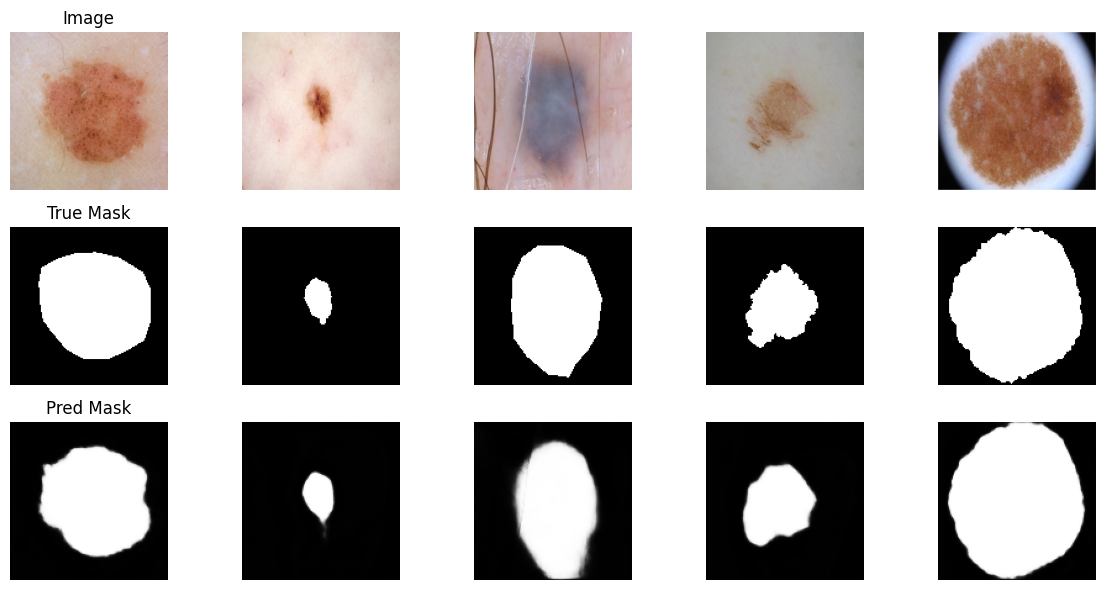

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# =============================
# 1️⃣ LOAD RESIZED DATA
# =============================
benign_images = np.load("/content/drive/MyDrive/ISIC_Image_NPY/benign_images_resized.npy")
malignant_images = np.load("/content/drive/MyDrive/ISIC_Image_NPY/malignant_images_resized.npy")

benign_masks = np.load("/content/drive/MyDrive/ISIC_Segmentation_NPY/benign_masks_resized.npy")
malignant_masks = np.load("/content/drive/MyDrive/ISIC_Segmentation_NPY/malignant_masks_resized.npy")

# Merge benign + malignant
X = np.concatenate([benign_images, malignant_images], axis=0)
y = np.concatenate([benign_masks, malignant_masks], axis=0)

# Normalize images
X = X.astype("float32") / 255.0
# Ensure masks are binary
y = (y > 127).astype("float32")
y = np.expand_dims(y, axis=-1) if y.ndim == 3 else y

print("Images shape:", X.shape)
print("Masks shape:", y.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =============================
# 2️⃣ UNet++ MODEL
# =============================
def convolution_block(x, num_filters, kernel_size=3):
    x = layers.Conv2D(num_filters, kernel_size, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def encoder(input_tensor):
    base_model = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=input_tensor
    )
    skips = [
        base_model.get_layer("conv1_relu").output,
        base_model.get_layer("conv2_block3_2_relu").output,
        base_model.get_layer("conv3_block4_2_relu").output,
        base_model.get_layer("conv4_block6_2_relu").output
    ]
    encoder_output = base_model.get_layer("conv5_block3_out").output
    return skips, encoder_output

def decoder(skips, encoder_output, num_classes):
    x = encoder_output
    x = layers.UpSampling2D((2, 2), interpolation="bilinear")(x)
    x = layers.Concatenate()([x, skips[3]])
    x = convolution_block(x, 256)

    x = layers.UpSampling2D((2, 2), interpolation="bilinear")(x)
    x = layers.Concatenate()([x, skips[2]])
    x = convolution_block(x, 128)

    x = layers.UpSampling2D((2, 2), interpolation="bilinear")(x)
    x = layers.Concatenate()([x, skips[1]])
    x = convolution_block(x, 64)

    x = layers.UpSampling2D((2, 2), interpolation="bilinear")(x)
    x = layers.Concatenate()([x, skips[0]])
    x = convolution_block(x, 32)

    x = layers.Conv2D(num_classes, (1, 1), padding="same")(x)
    return x

def UNetPP(image_size, num_classes):
    inputs = keras.Input(shape=(image_size, image_size, 3))
    skips, encoder_output = encoder(inputs)
    outputs = decoder(skips, encoder_output, num_classes)
    return keras.Model(inputs, outputs)

# =============================
# 3️⃣ LOSS FUNCTION
# =============================
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.nn.sigmoid(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 1 - (2. * intersection + 1) / (union + 1)

loss_fn = lambda y_true, y_pred: keras.losses.BinaryCrossentropy(from_logits=True)(y_true, y_pred) + dice_loss(y_true, y_pred)

# =============================
# 4️⃣ COMPILE & TRAIN
# =============================
IMAGE_SIZE = X.shape[1]
NUM_CLASSES = 1

model = UNetPP(IMAGE_SIZE, NUM_CLASSES)
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=loss_fn,
    metrics=[keras.metrics.BinaryAccuracy(threshold=0.5)]
)

model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=20
)

# =============================
# 5️⃣ VISUALIZE PREDICTIONS
# =============================
preds = model.predict(X_test[:5])
preds = tf.nn.sigmoid(preds).numpy()

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[i])
    plt.axis("off")
    if i == 0: plt.title("Image")

    plt.subplot(3, 5, i+6)
    plt.imshow(y_test[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == 0: plt.title("True Mask")

    plt.subplot(3, 5, i+11)
    plt.imshow(preds[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == 0: plt.title("Pred Mask")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Load the .npy file
masks = np.load("/content/drive/MyDrive/ISIC_Segmentation_NPY/benign_masks.npy")

# Print array information
print("Shape:", masks.shape)         # Number of masks and their height/width
print("Data type:", masks.dtype)     # e.g., uint8, float32
print("Min value:", masks.min())
print("Max value:", masks.max())

# Optional: check the size of a single mask
print("Single mask shape:", masks[0].shape)


Shape: (727, 256, 256)
Data type: uint8
Min value: 0
Max value: 255
Single mask shape: (256, 256)


Images shape: (900, 256, 256, 3)
Masks shape: (900, 256, 256, 1)
Train shapes: (720, 256, 256, 3) (720, 256, 256, 1)
Test shapes: (180, 256, 256, 3) (180, 256, 256, 1)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 256, 256)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 256, 256)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 256, 256)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 256, 256,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256, 256,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ add_2[0][0]       │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 11,295,105 (43.09 MB)

 Trainable params: 11,262,977 (42.96 MB)

 Non-trainable params: 32,128 (125.50 KB)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 90s 348ms/step - binary_accuracy: 0.8730 - loss: 0.3271 - val_binary_accuracy: 0.7612 - val_loss: 0.6340
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 254ms/step - binary_accuracy: 0.9419 - loss: 0.1423 - val_binary_accuracy: 0.7451 - val_loss: 0.4824
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 251ms/step - binary_accuracy: 0.9387 - loss: 0.1404 - val_binary_accuracy: 0.4406 - val_loss: 8.9621
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 253ms/step - binary_accuracy: 0.9548 - loss: 0.1061 - val_binary_accuracy: 0.7285 - val_loss: 0.8000
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 249ms/step - binary_accuracy: 0.9609 - loss: 0.0925 - val_binary_accuracy: 0.7285 - val_loss: 0.9782
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 262ms/step - binary_accuracy: 0.9638 - loss: 0.0833 - val_binary_accuracy: 0.7389 - val_loss: 0.8678
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 251ms/step - binary_accuracy: 0.9656 - loss: 0.0773 - val_binary_accuracy: 0.8367 - val_loss: 0.3935

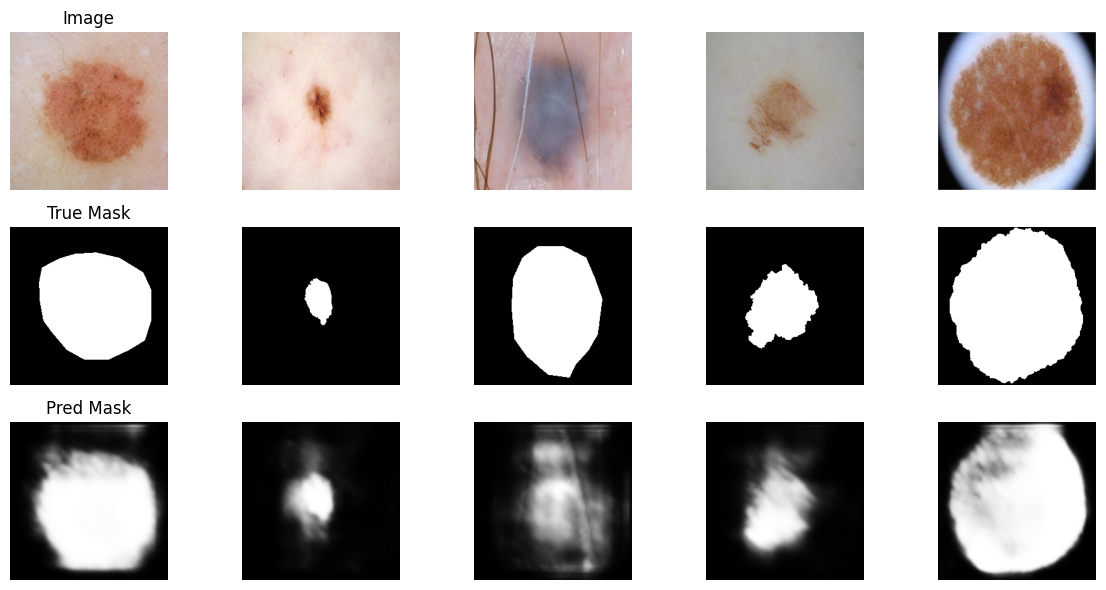

In [ ]:
# =============================
# 1️⃣ IMPORTS
# =============================
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# =============================
# 2️⃣ LOAD DATA
# =============================
benign_images = np.load("/content/drive/MyDrive/ISIC_Image_NPY/benign_images_resized.npy")
malignant_images = np.load("/content/drive/MyDrive/ISIC_Image_NPY/malignant_images_resized.npy")

benign_masks = np.load("/content/drive/MyDrive/ISIC_Segmentation_NPY/benign_masks.npy")
malignant_masks = np.load("/content/drive/MyDrive/ISIC_Segmentation_NPY/malignant_masks.npy")

# =============================
# 3️⃣ RESIZE MASKS TO 256x256
# =============================
def resize_masks(masks, target_size=(256, 256)):
    resized = np.array([cv2.resize(mask.squeeze(), target_size, interpolation=cv2.INTER_NEAREST) for mask in masks])
    resized = np.expand_dims(resized, axis=-1)
    return resized

benign_masks_resized = resize_masks(benign_masks)
malignant_masks_resized = resize_masks(malignant_masks)

# =============================
# 4️⃣ MERGE DATA
# =============================
X = np.concatenate([benign_images, malignant_images], axis=0).astype("float32") / 255.0
y = np.concatenate([benign_masks_resized, malignant_masks_resized], axis=0).astype("float32")
y = (y > 0).astype("float32")  # binary masks

print("Images shape:", X.shape)
print("Masks shape:", y.shape)

# =============================
# 5️⃣ TRAIN-TEST SPLIT
# =============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

# =============================
# 6️⃣ DEEPLABV3++ MODEL
# =============================
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, use_bias=False):
    x = layers.Conv2D(
        num_filters, kernel_size, dilation_rate=dilation_rate,
        padding="same", use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal()
    )(block_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, num_filters=256, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation='bilinear'
    )(x)
    out_1 = convolution_block(dspp_input, num_filters=256, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, num_filters=256, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, num_filters=256, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, num_filters=256, kernel_size=3, dilation_rate=18)
    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, num_filters=256, kernel_size=1)
    return output

def encoder(model_input):
    preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=preprocessed)
    low_level_features = resnet50.get_layer("conv2_block3_2_relu").output
    encoder_output = resnet50.get_layer("conv4_block6_2_relu").output
    dspp_output = DilatedSpatialPyramidPooling(encoder_output)
    return low_level_features, dspp_output

def decoder(low_level_features, dspp_output, num_classes):
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(dspp_output)
    x = layers.Concatenate()([x, low_level_features])
    x = convolution_block(x, num_filters=256)
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return model_output

def DeepLabV3Plus(image_size, num_classes):
    inputs = keras.Input(shape=(image_size, image_size, 3))
    low_level_features, dspp_output = encoder(inputs)
    outputs = decoder(low_level_features, dspp_output, num_classes)
    return keras.Model(inputs, outputs)

# =============================
# 7️⃣ COMPILE MODEL
# =============================
IMAGE_SIZE = X.shape[1]
NUM_CLASSES = 1

model = DeepLabV3Plus(IMAGE_SIZE, NUM_CLASSES)
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(threshold=0.5)]
)

model.summary()

# =============================
# 8️⃣ TRAIN
# =============================
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=20
)

# =============================
# 9️⃣ VISUALIZE PREDICTIONS
# =============================
preds = model.predict(X_test[:5])
preds = tf.nn.sigmoid(preds).numpy()

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[i])
    plt.axis("off")
    if i == 0: plt.title("Image")

    plt.subplot(3, 5, i+6)
    plt.imshow(y_test[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == 0: plt.title("True Mask")

    plt.subplot(3, 5, i+11)
    plt.imshow(preds[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == 0: plt.title("Pred Mask")

plt.tight_layout()
plt.show()


In [ ]:
# =============================
# 1️⃣ IMPORTS
# =============================
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# =============================
# 2️⃣ LOAD DATA
# =============================
benign_images = np.load("/content/drive/MyDrive/ISIC_Image_NPY/benign_images_resized.npy")
malignant_images = np.load("/content/drive/MyDrive/ISIC_Image_NPY/malignant_images_resized.npy")

benign_masks = np.load("/content/drive/MyDrive/ISIC_Segmentation_NPY/benign_masks.npy")
malignant_masks = np.load("/content/drive/MyDrive/ISIC_Segmentation_NPY/malignant_masks.npy")

# =============================
# 3️⃣ RESIZE MASKS TO 256x256
# =============================
def resize_masks(masks, target_size=(256, 256)):
    resized = np.array([cv2.resize(mask.squeeze(), target_size, interpolation=cv2.INTER_NEAREST) for mask in masks])
    resized = np.expand_dims(resized, axis=-1)
    return resized

benign_masks_resized = resize_masks(benign_masks)
malignant_masks_resized = resize_masks(malignant_masks)

# =============================
# 4️⃣ MERGE DATA
# =============================
X = np.concatenate([benign_images, malignant_images], axis=0).astype("float32") / 255.0
y = np.concatenate([benign_masks_resized, malignant_masks_resized], axis=0).astype("float32")
y = (y > 0).astype("float32")  # binary masks

print("Images shape:", X.shape)
print("Masks shape:", y.shape)

# =============================
# 5️⃣ TRAIN-TEST SPLIT
# =============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

# =============================
# 6️⃣ DEEPLABV3++ MODEL
# =============================
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, use_bias=False):
    x = layers.Conv2D(
        num_filters, kernel_size, dilation_rate=dilation_rate,
        padding="same", use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal()
    )(block_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, num_filters=256, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation='bilinear'
    )(x)
    out_1 = convolution_block(dspp_input, num_filters=256, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, num_filters=256, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, num_filters=256, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, num_filters=256, kernel_size=3, dilation_rate=18)
    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, num_filters=256, kernel_size=1)
    return output

def encoder(model_input):
    preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=preprocessed)
    low_level_features = resnet50.get_layer("conv2_block3_2_relu").output
    encoder_output = resnet50.get_layer("conv4_block6_2_relu").output
    dspp_output = DilatedSpatialPyramidPooling(encoder_output)
    return low_level_features, dspp_output

def decoder(low_level_features, dspp_output, num_classes):
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(dspp_output)
    x = layers.Concatenate()([x, low_level_features])
    x = convolution_block(x, num_filters=256)
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return model_output

def DeepLabV3Plus(image_size, num_classes):
    inputs = keras.Input(shape=(image_size, image_size, 3))
    low_level_features, dspp_output = encoder(inputs)
    outputs = decoder(low_level_features, dspp_output, num_classes)
    return keras.Model(inputs, outputs)

# =============================
# 7️⃣ COMPILE MODEL
# =============================
IMAGE_SIZE = X.shape[1]
NUM_CLASSES = 1

# Optional: define IoU metric
def iou_metric(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-7)

# Optional: define Dice coefficient
def dice_coef(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2.0 * intersection + 1e-7) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)

model = DeepLabV3Plus(IMAGE_SIZE, NUM_CLASSES)
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(threshold=0.5), iou_metric, dice_coef]
)

model.summary()

# =============================
# 8️⃣ TRAIN
# =============================
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=20
)

# =============================
# 9️⃣ SAVE MODEL
# =============================
model.save("/content/drive/MyDrive/DeepLabV3Plus_model")

# =============================
# 🔟 LOAD MODEL & EVALUATE
# =============================
loaded_model = keras.models.load_model(
    "/content/drive/MyDrive/DeepLabV3Plus_model",
    custom_objects={"iou_metric": iou_metric, "dice_coef": dice_coef}
)

loss, accuracy, iou, dice = loaded_model.evaluate(X_test, y_test, batch_size=8)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("IoU:", iou)
print("Dice Coefficient:", dice)

# =============================
# 1️⃣1️⃣ VISUALIZE PREDICTIONS
# =============================
preds = loaded_model.predict(X_test[:5])
preds = tf.nn.sigmoid(preds).numpy()

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[i])
    plt.axis("off")
    if i == 0: plt.title("Image")

    plt.subplot(3, 5, i+6)
    plt.imshow(y_test[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == 0: plt.title("True Mask")

    plt.subplot(3, 5, i+11)
    plt.imshow(preds[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == 0: plt.title("Pred Mask")

plt.tight_layout()
plt.show()


Images shape: (900, 256, 256, 3)
Masks shape: (900, 256, 256, 1)
Train shapes: (720, 256, 256, 3) (720, 256, 256, 1)
Test shapes: (180, 256, 256, 3) (180, 256, 256, 1)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 256, 256)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 256, 256)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 256, 256)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 256, 256,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ add[0][0]         │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c

 Total params: 11,295,105 (43.09 MB)

 Trainable params: 11,262,977 (42.96 MB)

 Non-trainable params: 32,128 (125.50 KB)

Epoch 1/20
11/90 ━━━━━━━━━━━━━━━━━━━━ 21:01 16s/step - binary_accuracy: 0.6006 - dice_coef: 0.5201 - iou_metric: 0.3701 - loss: 0.8469

KeyboardInterrupt: 

Images shape: (900, 256, 256, 3)
Masks shape: (900, 128, 128, 1)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 29,488,385 (112.49 MB)

 Trainable params: 29,434,305 (112.28 MB)

 Non-trainable params: 54,080 (211.25 KB)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - dice_coef: 0.5928 - iou_m: 0.4329 - loss: 0.4530 - recall_m: 0.4447
Epoch 1: val_loss improved from inf to 0.90737, saving model to /content/drive/MyDrive/unetpp_best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 134s 599ms/step - dice_coef: 0.5936 - iou_m: 0.4337 - loss: 0.4520 - recall_m: 0.4438 - val_dice_coef: 0.1928 - val_iou_m: 0.1072 - val_loss: 0.9074 - val_recall_m: 0.1632
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - dice_coef: 0.7504 - iou_m: 0.6062 - loss: 0.2659 - recall_m: 0.3054
Epoch 2: val_loss did not improve from 0.90737
90/90 ━━━━━━━━━━━━━━━━━━━━ 73s 298ms/step - dice_coef: 0.7503 - iou_m: 0.6061 - loss: 0.2659 - recall_m: 0.3053 - val_dice_coef: 0.1846 - val_iou_m: 0.1021 - val_loss: 0.9156 - val_recall_m: 0.0779
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - dice_coef: 0.7738 - iou_m: 0.6395 - loss: 0.2399 - recall_m: 0.2982
Epoch 3: val_loss did not improve from 0.90737
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - dice_coef: 0.7738 - iou_m: 0.6395 - loss: 0.2399 - recall_m: 0.2981 - val_dice_coef: 0.1751 - val_iou_m: 0.0962 - val_loss: 0.9194 - val_recall_m: 0.0000e+00
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - dice_coef

90/90 ━━━━━━━━━━━━━━━━━━━━ 37s 413ms/step - dice_coef: 0.8466 - iou_m: 0.7393 - loss: 0.1617 - recall_m: 0.2921 - val_dice_coef: 0.3048 - val_iou_m: 0.1811 - val_loss: 0.7778 - val_recall_m: 0.0316
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - dice_coef: 0.8545 - iou_m: 0.7515 - loss: 0.1520 - recall_m: 0.2790
Epoch 7: val_loss improved from 0.77784 to 0.37061, saving model to /content/drive/MyDrive/unetpp_best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 426ms/step - dice_coef: 0.8546 - iou_m: 0.7515 - loss: 0.1520 - recall_m: 0.2790 - val_dice_coef: 0.6710 - val_iou_m: 0.5079 - val_loss: 0.3706 - val_recall_m: 0.2260
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - dice_coef: 0.8647 - iou_m: 0.7662 - loss: 0.1416 - recall_m: 0.2736
Epoch 8: val_loss improved from 0.37061 to 0.30340, saving model to /content/drive/MyDrive/unetpp_best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 384ms/step - dice_coef: 0.8647 - iou_m: 0.7662 - loss: 0.1415 - recall_m: 0.2736 - val_dice_coef: 0.7364 - val_iou_m: 0.5853 - val_loss: 0.3034 - val_recall_m: 0.2600
Epoch 9/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - dice_coef: 0.8735 - iou_m: 0.7802 - loss: 0.1327 - recall_m: 0.2750
Epoch 9: val_loss improved from 0.30340 to 0.23941, saving model to /content/drive/MyDrive/unetpp_best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 361ms/step - dice_coef: 0.8735 - iou_m: 0.7803 - loss: 0.1327 - recall_m: 0.2750 - val_dice_coef: 0.7951 - val_iou_m: 0.6616 - val_loss: 0.2394 - val_recall_m: 0.2745
Epoch 10/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - dice_coef: 0.8899 - iou_m: 0.8052 - loss: 0.1153 - recall_m: 0.2713
Epoch 10: val_loss improved from 0.23941 to 0.19863, saving model to /content/drive/MyDrive/unetpp_best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 364ms/step - dice_coef: 0.8900 - iou_m: 0.8052 - loss: 0.1153 - recall_m: 0.2713 - val_dice_coef: 0.8319 - val_iou_m: 0.7130 - val_loss: 0.1986 - val_recall_m: 0.2716
Epoch 11/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - dice_coef: 0.8950 - iou_m: 0.8145 - loss: 0.1107 - recall_m: 0.2764
Epoch 11: val_loss improved from 0.19863 to 0.17685, saving model to /content/drive/MyDrive/unetpp_best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 364ms/step - dice_coef: 0.8950 - iou_m: 0.8145 - loss: 0.1107 - recall_m: 0.2764 - val_dice_coef: 0.8503 - val_iou_m: 0.7410 - val_loss: 0.1768 - val_recall_m: 0.2675
Epoch 12/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - dice_coef: 0.9018 - iou_m: 0.8235 - loss: 0.1037 - recall_m: 0.2676
Epoch 12: val_loss improved from 0.17685 to 0.16058, saving model to /content/drive/MyDrive/unetpp_best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 479ms/step - dice_coef: 0.9018 - iou_m: 0.8235 - loss: 0.1036 - recall_m: 0.2676 - val_dice_coef: 0.8662 - val_iou_m: 0.7646 - val_loss: 0.1606 - val_recall_m: 0.2557
Epoch 13/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - dice_coef: 0.9073 - iou_m: 0.8337 - loss: 0.0982 - recall_m: 0.2722
Epoch 13: val_loss improved from 0.16058 to 0.15165, saving model to /content/drive/MyDrive/unetpp_best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 359ms/step - dice_coef: 0.9073 - iou_m: 0.8337 - loss: 0.0982 - recall_m: 0.2722 - val_dice_coef: 0.8758 - val_iou_m: 0.7797 - val_loss: 0.1517 - val_recall_m: 0.2735
Epoch 14/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - dice_coef: 0.9173 - iou_m: 0.8495 - loss: 0.0879 - recall_m: 0.2699
Epoch 14: val_loss improved from 0.15165 to 0.14638, saving model to /content/drive/MyDrive/unetpp_best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 37s 416ms/step - dice_coef: 0.9173 - iou_m: 0.8495 - loss: 0.0879 - recall_m: 0.2699 - val_dice_coef: 0.8812 - val_iou_m: 0.7882 - val_loss: 0.1464 - val_recall_m: 0.2638
Epoch 15/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - dice_coef: 0.9252 - iou_m: 0.8627 - loss: 0.0801 - recall_m: 0.2788
Epoch 15: val_loss improved from 0.14638 to 0.14286, saving model to /content/drive/MyDrive/unetpp_best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 391ms/step - dice_coef: 0.9252 - iou_m: 0.8627 - loss: 0.0801 - recall_m: 0.2788 - val_dice_coef: 0.8835 - val_iou_m: 0.7921 - val_loss: 0.1429 - val_recall_m: 0.2531
Epoch 16/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - dice_coef: 0.9228 - iou_m: 0.8591 - loss: 0.0823 - recall_m: 0.2636
Epoch 16: val_loss improved from 0.14286 to 0.14048, saving model to /content/drive/MyDrive/unetpp_best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 362ms/step - dice_coef: 0.9229 - iou_m: 0.8592 - loss: 0.0822 - recall_m: 0.2637 - val_dice_coef: 0.8906 - val_iou_m: 0.8034 - val_loss: 0.1405 - val_recall_m: 0.2579
Epoch 17/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - dice_coef: 0.9296 - iou_m: 0.8708 - loss: 0.0755 - recall_m: 0.2708
Epoch 17: val_loss improved from 0.14048 to 0.13925, saving model to /content/drive/MyDrive/unetpp_best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 335ms/step - dice_coef: 0.9296 - iou_m: 0.8708 - loss: 0.0755 - recall_m: 0.2708 - val_dice_coef: 0.8924 - val_iou_m: 0.8063 - val_loss: 0.1393 - val_recall_m: 0.2657
Epoch 18/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - dice_coef: 0.9364 - iou_m: 0.8813 - loss: 0.0680 - recall_m: 0.2578
Epoch 18: val_loss improved from 0.13925 to 0.13715, saving model to /content/drive/MyDrive/unetpp_best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 431ms/step - dice_coef: 0.9364 - iou_m: 0.8814 - loss: 0.0679 - recall_m: 0.2580 - val_dice_coef: 0.8946 - val_iou_m: 0.8100 - val_loss: 0.1372 - val_recall_m: 0.2622
Epoch 19/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - dice_coef: 0.9410 - iou_m: 0.8898 - loss: 0.0638 - recall_m: 0.2695
Epoch 19: val_loss did not improve from 0.13715
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 311ms/step - dice_coef: 0.9410 - iou_m: 0.8898 - loss: 0.0638 - recall_m: 0.2695 - val_dice_coef: 0.8753 - val_iou_m: 0.7809 - val_loss: 0.1772 - val_recall_m: 0.2913
Epoch 20/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - dice_coef: 0.9284 - iou_m: 0.8677 - loss: 0.0819 - recall_m: 0.2680
Epoch 20: val_loss did not improve from 0.13715
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 325ms/step - dice_coef: 0.9284 - iou_m: 0.8676 - loss: 0.0820 - recall_m: 0.2681 - val_dice_coef: 0.8768 - val_iou_m: 0.7825 - val_loss: 0.1683 - val_recall_m: 0.2611
Epoch 21/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - dice_coef

90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 471ms/step - dice_coef: 0.9504 - iou_m: 0.9063 - loss: 0.0546 - recall_m: 0.2721 - val_dice_coef: 0.8976 - val_iou_m: 0.8150 - val_loss: 0.1355 - val_recall_m: 0.2528
Epoch 25/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - dice_coef: 0.9556 - iou_m: 0.9157 - loss: 0.0489 - recall_m: 0.2685
Epoch 25: val_loss did not improve from 0.13547
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 311ms/step - dice_coef: 0.9556 - iou_m: 0.9157 - loss: 0.0489 - recall_m: 0.2685 - val_dice_coef: 0.8984 - val_iou_m: 0.8163 - val_loss: 0.1375 - val_recall_m: 0.2479
Epoch 26/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - dice_coef: 0.9572 - iou_m: 0.9187 - loss: 0.0472 - recall_m: 0.2788
Epoch 26: val_loss improved from 0.13547 to 0.13097, saving model to /content/drive/MyDrive/unetpp_best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 51s 422ms/step - dice_coef: 0.9571 - iou_m: 0.9187 - loss: 0.0472 - recall_m: 0.2787 - val_dice_coef: 0.9040 - val_iou_m: 0.8254 - val_loss: 0.1310 - val_recall_m: 0.2544
Epoch 27/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - dice_coef: 0.9556 - iou_m: 0.9157 - loss: 0.0486 - recall_m: 0.2638
Epoch 27: val_loss did not improve from 0.13097
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 311ms/step - dice_coef: 0.9556 - iou_m: 0.9157 - loss: 0.0485 - recall_m: 0.2639 - val_dice_coef: 0.9057 - val_iou_m: 0.8284 - val_loss: 0.1319 - val_recall_m: 0.2567
Epoch 28/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - dice_coef: 0.9631 - iou_m: 0.9292 - loss: 0.0411 - recall_m: 0.2763
Epoch 28: val_loss did not improve from 0.13097
90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 326ms/step - dice_coef: 0.9631 - iou_m: 0.9292 - loss: 0.0411 - recall_m: 0.2763 - val_dice_coef: 0.9065 - val_iou_m: 0.8296 - val_loss: 0.1322 - val_recall_m: 0.2606
Epoch 29/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - dice_coef

✅ Model saved in Google Drive: unetpp_final_model.h5
Total Loss: 0.1353
Dice Coefficient (F1): 0.9070
Recall: 0.2547
Mean IoU: 0.8306
Dice Loss: 0.0930
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 322ms/step
Focal Loss: 0.0415
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


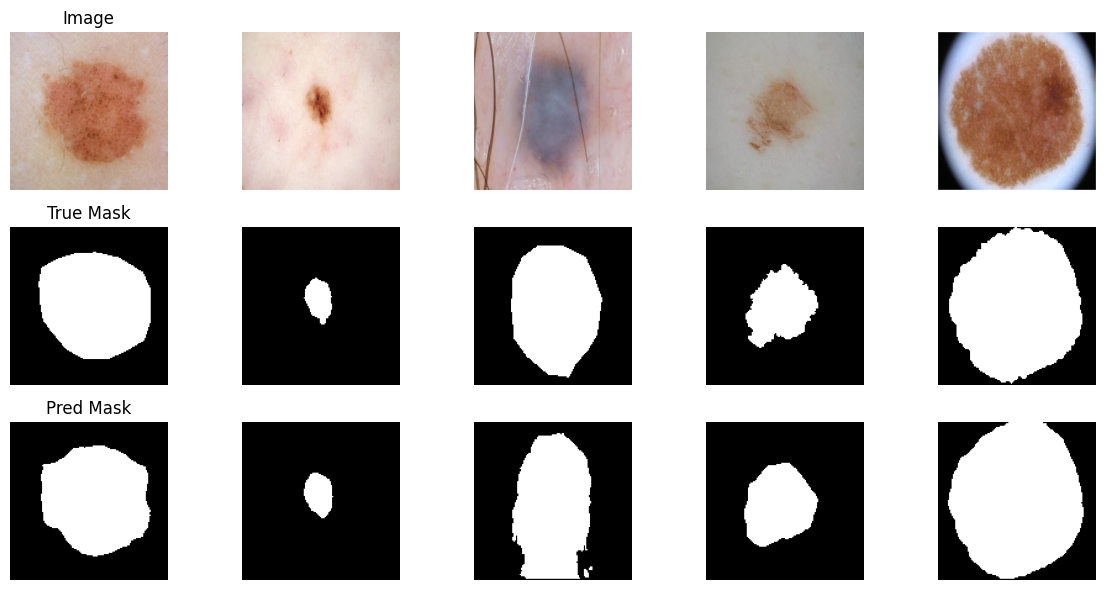

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

# =============================
# 1️⃣ LOAD RESIZED DATA
# =============================
benign_images = np.load("/content/drive/MyDrive/ISIC_Image_NPY/benign_images_resized.npy")
malignant_images = np.load("/content/drive/MyDrive/ISIC_Image_NPY/malignant_images_resized.npy")

benign_masks = np.load("/content/drive/MyDrive/ISIC_Segmentation_NPY/benign_masks_resized.npy")
malignant_masks = np.load("/content/drive/MyDrive/ISIC_Segmentation_NPY/malignant_masks_resized.npy")

# Merge benign + malignant
X = np.concatenate([benign_images, malignant_images], axis=0)
y = np.concatenate([benign_masks, malignant_masks], axis=0)

# Normalize images
X = X.astype("float32") / 255.0
# Ensure masks are binary
y = (y > 127).astype("float32")
y = np.expand_dims(y, axis=-1) if y.ndim == 3 else y

print("Images shape:", X.shape)
print("Masks shape:", y.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =============================
# 2️⃣ METRICS & LOSSES
# =============================
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(tf.nn.sigmoid(y_pred), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def recall_m(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.cast(tf.nn.sigmoid(y_pred) > 0.5, tf.float32)
    tp = tf.reduce_sum(y_true_f * y_pred_f)
    fn = tf.reduce_sum(y_true_f * (1 - y_pred_f))
    return tp / (tp + fn + 1e-6)

def iou_m(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(tf.nn.sigmoid(y_pred), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def focal_loss(y_true, y_pred, gamma=2., alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.nn.sigmoid(y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = tf.exp(-bce)
    focal = alpha * tf.pow((1 - bce_exp), gamma) * bce
    return tf.reduce_mean(focal)

def total_loss(y_true, y_pred):
    return focal_loss(y_true, y_pred) + dice_loss(y_true, y_pred)

# =============================
# 3️⃣ UNet++ MODEL
# =============================
def convolution_block(x, num_filters, kernel_size=3):
    x = layers.Conv2D(num_filters, kernel_size, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def encoder(input_tensor):
    base_model = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=input_tensor
    )
    skips = [
        base_model.get_layer("conv1_relu").output,
        base_model.get_layer("conv2_block3_2_relu").output,
        base_model.get_layer("conv3_block4_2_relu").output,
        base_model.get_layer("conv4_block6_2_relu").output
    ]
    encoder_output = base_model.get_layer("conv5_block3_out").output
    return skips, encoder_output

def decoder(skips, encoder_output, num_classes):
    x = encoder_output
    x = layers.UpSampling2D((2, 2), interpolation="bilinear")(x)
    x = layers.Concatenate()([x, skips[3]])
    x = convolution_block(x, 256)

    x = layers.UpSampling2D((2, 2), interpolation="bilinear")(x)
    x = layers.Concatenate()([x, skips[2]])
    x = convolution_block(x, 128)

    x = layers.UpSampling2D((2, 2), interpolation="bilinear")(x)
    x = layers.Concatenate()([x, skips[1]])
    x = convolution_block(x, 64)

    x = layers.UpSampling2D((2, 2), interpolation="bilinear")(x)
    x = layers.Concatenate()([x, skips[0]])
    x = convolution_block(x, 32)

    x = layers.Conv2D(num_classes, (1, 1), padding="same")(x)
    return x

def UNetPP(image_size, num_classes):
    inputs = keras.Input(shape=(image_size, image_size, 3))
    skips, encoder_output = encoder(inputs)
    outputs = decoder(skips, encoder_output, num_classes)
    return keras.Model(inputs, outputs)

# =============================
# 4️⃣ COMPILE & TRAIN
# =============================
IMAGE_SIZE = X.shape[1]
NUM_CLASSES = 1

model = UNetPP(IMAGE_SIZE, NUM_CLASSES)
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=total_loss,
    metrics=[dice_coef, recall_m, iou_m]
)

model.summary()

checkpoint_cb = ModelCheckpoint(
    filepath="/content/drive/MyDrive/unetpp_best_model.h5",  # ✅ Save directly to Google Drive
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=30,
    callbacks=[checkpoint_cb]
)

# Save final model to Drive
model.save("/content/drive/MyDrive/unetpp_final_model.h5")
print("✅ Model saved in Google Drive: unetpp_final_model.h5")

# =============================
# 5️⃣ EVALUATE ON TEST SET
# =============================
loss_val, dice_val, recall_val, iou_val = model.evaluate(X_test, y_test, batch_size=8, verbose=0)
print(f"Total Loss: {loss_val:.4f}")
print(f"Dice Coefficient (F1): {dice_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"Mean IoU: {iou_val:.4f}")
print(f"Dice Loss: {1 - dice_val:.4f}")
print(f"Focal Loss: {focal_loss(y_test, model.predict(X_test, batch_size=8)).numpy():.4f}")

# =============================
# 6️⃣ VISUALIZE 5 EXAMPLES
# =============================
preds = model.predict(X_test[:5])
preds_bin = (tf.nn.sigmoid(preds) > 0.5).numpy()

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[i])
    plt.axis("off")
    if i == 0: plt.title("Image")

    plt.subplot(3, 5, i+6)
    plt.imshow(y_test[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == 0: plt.title("True Mask")

    plt.subplot(3, 5, i+11)
    plt.imshow(preds_bin[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == 0: plt.title("Pred Mask")

plt.tight_layout()
plt.show()


Test set shape: (180, 256, 256, 3) (180, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

Metrics for these 5 images:
Dice Coef (F1): 0.9459
Recall: 0.9440
mIoU: 0.8973
Dice Loss: 0.0541
Focal Loss: 0.0172


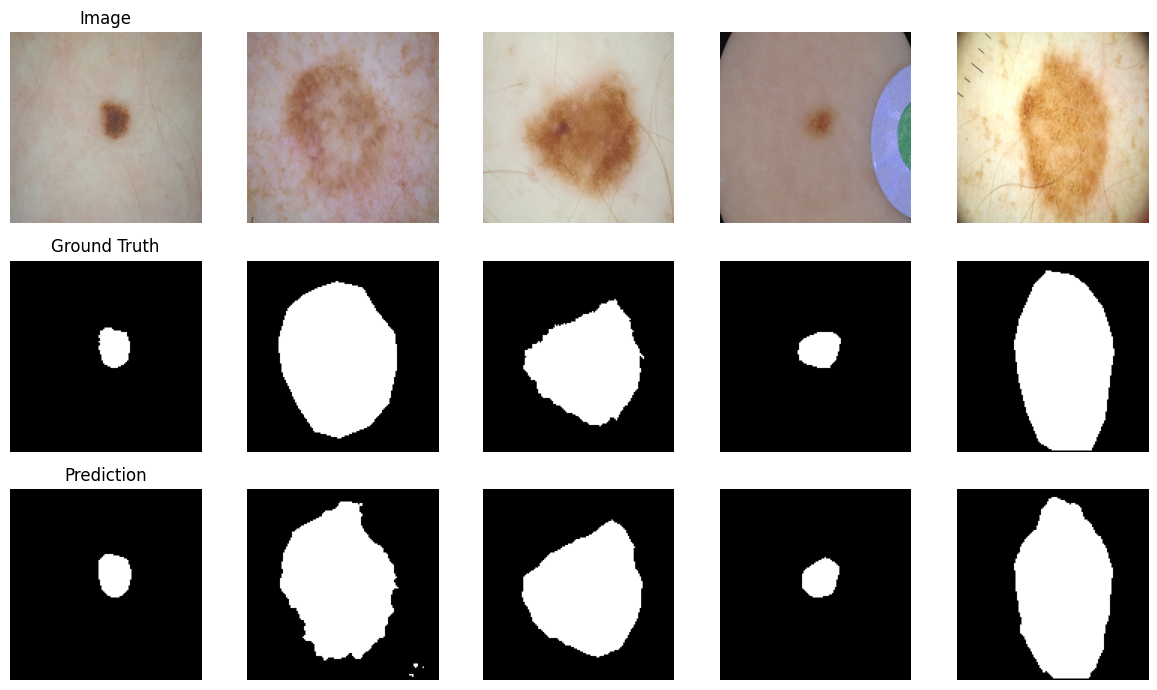

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random

# =============================
# 1️⃣ LOAD TEST DATA
# =============================
benign_images = np.load("/content/drive/MyDrive/ISIC_Image_NPY/benign_images_resized.npy")
malignant_images = np.load("/content/drive/MyDrive/ISIC_Image_NPY/malignant_images_resized.npy")

benign_masks = np.load("/content/drive/MyDrive/ISIC_Segmentation_NPY/benign_masks_resized.npy")
malignant_masks = np.load("/content/drive/MyDrive/ISIC_Segmentation_NPY/malignant_masks_resized.npy")

X = np.concatenate([benign_images, malignant_images], axis=0)
y = np.concatenate([benign_masks, malignant_masks], axis=0)

X = X.astype("float32") / 255.0
y = (y > 127).astype("float32")
y = np.expand_dims(y, axis=-1) if y.ndim == 3 else y

from sklearn.model_selection import train_test_split
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Test set shape:", X_test.shape, y_test.shape)

# =============================
# 2️⃣ METRICS (NUMPY VERSION)
# =============================
def dice_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def recall_np(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = (y_pred.flatten() > 0.5).astype(np.float32)
    tp = np.sum(y_true_f * y_pred_f)
    fn = np.sum(y_true_f * (1 - y_pred_f))
    return tp / (tp + fn + 1e-6)

def iou_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = (y_pred.flatten() > 0.5).astype(np.float32)
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_loss_np(y_true, y_pred):
    return 1 - dice_np(y_true, y_pred)

def focal_loss_np(y_true, y_pred, gamma=2., alpha=0.25):
    y_pred = np.clip(y_pred, 1e-6, 1 - 1e-6)
    bce = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    bce_exp = np.exp(-bce)
    focal = alpha * ((1 - bce_exp) ** gamma) * bce
    return np.mean(focal)

# =============================
# 3️⃣ LOAD MODEL & PREDICT
# =============================
model = keras.models.load_model(
    "/content/drive/MyDrive/unetpp_final_model.h5",
    compile=False
)

# Pick 5 random test samples
idxs = random.sample(range(len(X_test)), 5)
sample_images = X_test[idxs]
sample_masks = y_test[idxs]

# Run prediction (GPU)
preds = model.predict(sample_images)
preds_sigmoid = 1 / (1 + np.exp(-preds))  # apply sigmoid
preds_bin = (preds_sigmoid > 0.5).astype(np.float32)

# =============================
# 4️⃣ METRIC CALCULATION
# =============================
print("\nMetrics for these 5 images:")
print(f"Dice Coef (F1): {dice_np(sample_masks, preds_bin):.4f}")
print(f"Recall: {recall_np(sample_masks, preds_bin):.4f}")
print(f"mIoU: {iou_np(sample_masks, preds_bin):.4f}")
print(f"Dice Loss: {dice_loss_np(sample_masks, preds_bin):.4f}")
print(f"Focal Loss: {focal_loss_np(sample_masks, preds_sigmoid):.4f}")

# =============================
# 5️⃣ VISUALIZE RESULTS
# =============================
plt.figure(figsize=(12, 7))
for i in range(5):
    # Input image
    plt.subplot(3, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.axis("off")
    if i == 0: plt.title("Image")

    # Ground truth mask
    plt.subplot(3, 5, i + 6)
    plt.imshow(sample_masks[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == 0: plt.title("Ground Truth")

    # Predicted mask
    plt.subplot(3, 5, i + 11)
    plt.imshow(preds_bin[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == 0: plt.title("Prediction")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# =============================
# 1️⃣ LOAD DATA
# =============================
benign_images = np.load("/content/drive/MyDrive/ISIC_Image_NPY/benign_images_resized.npy")
malignant_images = np.load("/content/drive/MyDrive/ISIC_Image_NPY/malignant_images_resized.npy")

benign_masks = np.load("/content/drive/MyDrive/ISIC_Segmentation_NPY/benign_masks_resized.npy")
malignant_masks = np.load("/content/drive/MyDrive/ISIC_Segmentation_NPY/malignant_masks_resized.npy")

X = np.concatenate([benign_images, malignant_images], axis=0)
y = np.concatenate([benign_masks, malignant_masks], axis=0)

X = X.astype("float32") / 255.0
y = (y > 127).astype("float32")
y = np.expand_dims(y, axis=-1) if y.ndim == 3 else y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")

# =============================
# 2️⃣ NUMPY METRIC FUNCTIONS
# =============================
def dice_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def recall_np(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = (y_pred.flatten() > 0.5).astype(np.float32)
    tp = np.sum(y_true_f * y_pred_f)
    fn = np.sum(y_true_f * (1 - y_pred_f))
    return tp / (tp + fn + 1e-6)

def iou_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = (y_pred.flatten() > 0.5).astype(np.float32)
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_loss_np(y_true, y_pred):
    return 1 - dice_np(y_true, y_pred)

def focal_loss_np(y_true, y_pred, gamma=2., alpha=0.25):
    y_pred = np.clip(y_pred, 1e-6, 1 - 1e-6)
    bce = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    bce_exp = np.exp(-bce)
    focal = alpha * ((1 - bce_exp) ** gamma) * bce
    return np.mean(focal)

# =============================
# 3️⃣ LOAD MODEL
# =============================
model = keras.models.load_model(
    "/content/drive/MyDrive/unetpp_final_model.h5",
    compile=False
)

# =============================
# 4️⃣ PREDICT & EVALUATE
# =============================
def evaluate_dataset(X_data, y_data, name="Dataset"):
    preds = model.predict(X_data, batch_size=4)  # small batch to avoid OOM
    preds_sigmoid = 1 / (1 + np.exp(-preds))
    preds_bin = (preds_sigmoid > 0.5).astype(np.float32)

    print(f"\n📊 Metrics for {name}:")
    print(f"Dice Coef (F1): {dice_np(y_data, preds_bin):.4f}")
    print(f"Recall: {recall_np(y_data, preds_bin):.4f}")
    print(f"mIoU: {iou_np(y_data, preds_bin):.4f}")
    print(f"Dice Loss: {dice_loss_np(y_data, preds_bin):.4f}")
    print(f"Focal Loss: {focal_loss_np(y_data, preds_sigmoid):.4f}")

# Train metrics
evaluate_dataset(X_train, y_train, "Train Set")

# Test metrics
evaluate_dataset(X_test, y_test, "Test Set")


Train shape: (720, 256, 256, 3), (720, 128, 128, 1)
Test shape: (180, 256, 256, 3), (180, 128, 128, 1)
180/180 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step

📊 Metrics for Train Set:
Dice Coef (F1): 0.9835
Recall: 0.9856
mIoU: 0.9676
Dice Loss: 0.0165
Focal Loss: 0.0035
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

📊 Metrics for Test Set:
Dice Coef (F1): 0.9148
Recall: 0.8880
mIoU: 0.8429
Dice Loss: 0.0852
Focal Loss: 0.0415


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - dice_coef: 0.9630 - iou_m: 0.9293 - loss: 0.0418 - recall_m: 0.2727

90/90 ━━━━━━━━━━━━━━━━━━━━ 106s 402ms/step - dice_coef: 0.9630 - iou_m: 0.9293 - loss: 0.0418 - recall_m: 0.2726 - val_dice_coef: 0.9094 - val_iou_m: 0.8349 - val_loss: 0.1342 - val_recall_m: 0.2609
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 305ms/step - dice_coef: 0.9538 - iou_m: 0.9123 - loss: 0.0556 - recall_m: 0.2719 - val_dice_coef: 0.9067 - val_iou_m: 0.8304 - val_loss: 0.1364 - val_recall_m: 0.2519
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 281ms/step - dice_coef: 0.9620 - iou_m: 0.9272 - loss: 0.0441 - recall_m: 0.2728 - val_dice_coef: 0.9061 - val_iou_m: 0.8291 - val_loss: 0.1361 - val_recall_m: 0.2501
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 306ms/step - dice_coef: 0.9611 - iou_m: 0.9255 - loss: 0.0452 - recall_m: 0.2709 - val_dice_coef: 0.9006 - val_iou_m: 0.8201 - val_loss: 0.1466 - val_recall_m: 0.2552
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - dice_coef: 0.9614 - iou_m: 0.9260 - loss: 0.0448 - recall_m: 0.2692

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 468ms/step - dice_coef: 0.9614 - iou_m: 0.9261 - loss: 0.0448 - recall_m: 0.2692 - val_dice_coef: 0.9105 - val_iou_m: 0.8362 - val_loss: 0.1332 - val_recall_m: 0.2675
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 311ms/step - dice_coef: 0.9649 - iou_m: 0.9324 - loss: 0.0411 - recall_m: 0.2720 - val_dice_coef: 0.9024 - val_iou_m: 0.8226 - val_loss: 0.1491 - val_recall_m: 0.2873
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - dice_coef: 0.9657 - iou_m: 0.9340 - loss: 0.0404 - recall_m: 0.2734

90/90 ━━━━━━━━━━━━━━━━━━━━ 53s 445ms/step - dice_coef: 0.9657 - iou_m: 0.9339 - loss: 0.0404 - recall_m: 0.2734 - val_dice_coef: 0.9106 - val_iou_m: 0.8365 - val_loss: 0.1330 - val_recall_m: 0.2751
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 313ms/step - dice_coef: 0.9655 - iou_m: 0.9335 - loss: 0.0405 - recall_m: 0.2754 - val_dice_coef: 0.9058 - val_iou_m: 0.8289 - val_loss: 0.1412 - val_recall_m: 0.2543
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 38s 284ms/step - dice_coef: 0.9686 - iou_m: 0.9393 - loss: 0.0367 - recall_m: 0.2726 - val_dice_coef: 0.8935 - val_iou_m: 0.8083 - val_loss: 0.1565 - val_recall_m: 0.2678
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 307ms/step - dice_coef: 0.9728 - iou_m: 0.9472 - loss: 0.0314 - recall_m: 0.2733 - val_dice_coef: 0.9062 - val_iou_m: 0.8293 - val_loss: 0.1413 - val_recall_m: 0.2558
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - dice_coef: 0.9729 - iou_m: 0.9474 - loss: 0.0310 - recall_m: 0.2720

90/90 ━━━━━━━━━━━━━━━━━━━━ 97s 428ms/step - dice_coef: 0.9729 - iou_m: 0.9474 - loss: 0.0310 - recall_m: 0.2720 - val_dice_coef: 0.9120 - val_iou_m: 0.8391 - val_loss: 0.1333 - val_recall_m: 0.2558
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - dice_coef: 0.9770 - iou_m: 0.9552 - loss: 0.0258 - recall_m: 0.2719

90/90 ━━━━━━━━━━━━━━━━━━━━ 53s 406ms/step - dice_coef: 0.9770 - iou_m: 0.9552 - loss: 0.0258 - recall_m: 0.2719 - val_dice_coef: 0.9132 - val_iou_m: 0.8411 - val_loss: 0.1319 - val_recall_m: 0.2552
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - dice_coef: 0.9788 - iou_m: 0.9587 - loss: 0.0236 - recall_m: 0.2722

90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 498ms/step - dice_coef: 0.9788 - iou_m: 0.9587 - loss: 0.0236 - recall_m: 0.2721 - val_dice_coef: 0.9139 - val_iou_m: 0.8423 - val_loss: 0.1316 - val_recall_m: 0.2545
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 65s 305ms/step - dice_coef: 0.9802 - iou_m: 0.9612 - loss: 0.0220 - recall_m: 0.2723 - val_dice_coef: 0.9143 - val_iou_m: 0.8429 - val_loss: 0.1320 - val_recall_m: 0.2541
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 283ms/step - dice_coef: 0.9812 - iou_m: 0.9632 - loss: 0.0208 - recall_m: 0.2725 - val_dice_coef: 0.9146 - val_iou_m: 0.8434 - val_loss: 0.1323 - val_recall_m: 0.2540
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 285ms/step - dice_coef: 0.9820 - iou_m: 0.9647 - loss: 0.0198 - recall_m: 0.2726 - val_dice_coef: 0.9148 - val_iou_m: 0.8438 - val_loss: 0.1328 - val_recall_m: 0.2539
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 287ms/step - dice_coef: 0.9826 - iou_m: 0.9659 - loss: 0.0191 - recall_m: 0.2727 - val_dice_coef: 0.9151 - val_iou_m: 0.8442 - val_lo


📊 Train Set Metrics:
Dice Coef (F1): 0.9833
Recall: 0.2670
mIoU: 0.9672
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step
Dice Loss: 0.0162
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step
Focal Loss: 0.0030

📊 Test Set Metrics:
Dice Coef (F1): 0.9140
Recall: 0.2516
mIoU: 0.8418
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 829ms/step
Dice Loss: 0.0872
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
Focal Loss: 0.0540
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


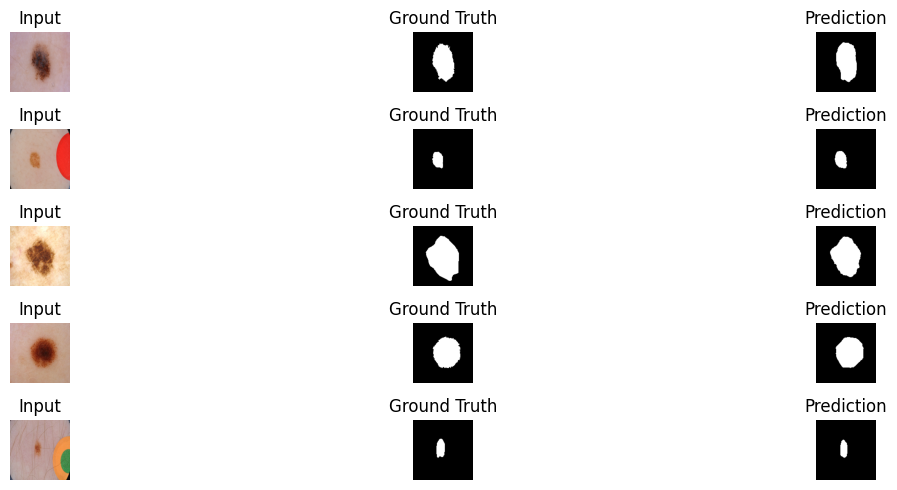

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# =============================
# 1️⃣ LOAD DATA
# =============================
benign_images = np.load("/content/drive/MyDrive/ISIC_Image_NPY/benign_images_resized.npy")
malignant_images = np.load("/content/drive/MyDrive/ISIC_Image_NPY/malignant_images_resized.npy")
benign_masks = np.load("/content/drive/MyDrive/ISIC_Segmentation_NPY/benign_masks_resized.npy")
malignant_masks = np.load("/content/drive/MyDrive/ISIC_Segmentation_NPY/malignant_masks_resized.npy")

X = np.concatenate([benign_images, malignant_images], axis=0).astype("float32") / 255.0
y = np.concatenate([benign_masks, malignant_masks], axis=0)
y = (y > 127).astype("float32")
y = np.expand_dims(y, axis=-1) if y.ndim == 3 else y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =============================
# 2️⃣ METRICS & LOSSES
# =============================
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(tf.nn.sigmoid(y_pred), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def recall_m(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.cast(tf.nn.sigmoid(y_pred) > 0.5, tf.float32)
    tp = tf.reduce_sum(y_true_f * y_pred_f)
    fn = tf.reduce_sum(y_true_f * (1 - y_pred_f))
    return tp / (tp + fn + 1e-6)

def iou_m(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(tf.nn.sigmoid(y_pred), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def focal_loss(y_true, y_pred, gamma=2., alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.nn.sigmoid(y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = tf.exp(-bce)
    focal = alpha * tf.pow((1 - bce_exp), gamma) * bce
    return tf.reduce_mean(focal)

def total_loss(y_true, y_pred):
    return focal_loss(y_true, y_pred) + dice_loss(y_true, y_pred)

# =============================
# 3️⃣ LOAD MODEL & FREEZE ENCODER
# =============================
model = keras.models.load_model(
    "/content/drive/MyDrive/unetpp_final_model.h5",
    custom_objects={
        "dice_coef": dice_coef,
        "recall_m": recall_m,
        "iou_m": iou_m,
        "dice_loss": dice_loss,
        "focal_loss": focal_loss,
        "total_loss": total_loss
    }
)

for layer in model.layers:
    if layer.name.startswith("resnet50"):
        layer.trainable = False

# =============================
# 4️⃣ TRAIN WITH FROZEN ENCODER
# =============================
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=total_loss,
              metrics=[dice_coef, recall_m, iou_m])

checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/unetpp_finetuned_stage1.h5", save_best_only=True)

model.fit(X_train, y_train, validation_data=(X_test, y_test),
          batch_size=8, epochs=10, callbacks=[checkpoint_cb])

# =============================
# 5️⃣ UNFREEZE & FINE-TUNE
# =============================
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=total_loss,
              metrics=[dice_coef, recall_m, iou_m])

checkpoint_cb2 = ModelCheckpoint("/content/drive/MyDrive/unetpp_finetuned_stage2.h5", save_best_only=True)

model.fit(X_train, y_train, validation_data=(X_test, y_test),
          batch_size=8, epochs=20, callbacks=[checkpoint_cb2])

model.save("/content/drive/MyDrive/unetpp_finetuned_final.h5")

# =============================
# 6️⃣ EVALUATE TRAIN & TEST SET
# =============================
train_metrics = model.evaluate(X_train, y_train, verbose=0)
test_metrics = model.evaluate(X_test, y_test, verbose=0)

print("\n📊 Train Set Metrics:")
print(f"Dice Coef (F1): {train_metrics[1]:.4f}")
print(f"Recall: {train_metrics[2]:.4f}")
print(f"mIoU: {train_metrics[3]:.4f}")
print(f"Dice Loss: {dice_loss(y_train, model.predict(X_train)).numpy():.4f}")
print(f"Focal Loss: {focal_loss(y_train, model.predict(X_train)).numpy():.4f}")

print("\n📊 Test Set Metrics:")
print(f"Dice Coef (F1): {test_metrics[1]:.4f}")
print(f"Recall: {test_metrics[2]:.4f}")
print(f"mIoU: {test_metrics[3]:.4f}")
print(f"Dice Loss: {dice_loss(y_test, model.predict(X_test)).numpy():.4f}")
print(f"Focal Loss: {focal_loss(y_test, model.predict(X_test)).numpy():.4f}")

# =============================
# 7️⃣ SHOW 5 RANDOM PREDICTIONS
# =============================
indices = np.random.choice(len(X_test), 5, replace=False)
preds = model.predict(X_test[indices])
preds_bin = (tf.nn.sigmoid(preds) > 0.5).numpy()

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(X_test[idx])
    plt.title("Input")
    plt.axis("off")

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(y_test[idx].squeeze(), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(preds_bin[i].squeeze(), cmap="gray")
    plt.title("Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()
